<a href="https://colab.research.google.com/github/ravijp/Kaggle_comp/blob/master/Jigsaw_Unintended_Bias_in_Toxicity_Classification_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import kaggle
!pip install kaggle

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
print(request)
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
# Download kaggle dataset
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

  0% 0.00/221k [00:00<?, ?B/s]
100% 221k/221k [00:00<00:00, 33.1MB/s]
 83% 10.0M/12.1M [00:00<00:00, 44.9MB/s]
100% 12.1M/12.1M [00:00<00:00, 47.8MB/s]
 97% 264M/273M [00:03<00:00, 107MB/s]
100% 273M/273M [00:03<00:00, 91.2MB/s]


In [0]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [0]:
# unzip training zip
zipfile.ZipFile('./train.csv.zip').extractall()
zipfile.ZipFile('test.csv.zip').extractall()
zipfile.ZipFile('sample_submission.csv.zip').extractall()

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

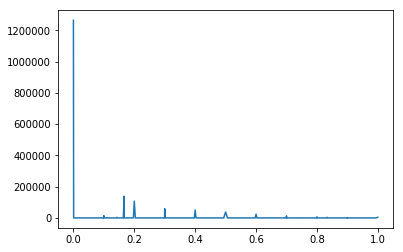

In [0]:
train['target'].value_counts().sort_index().plot.line()

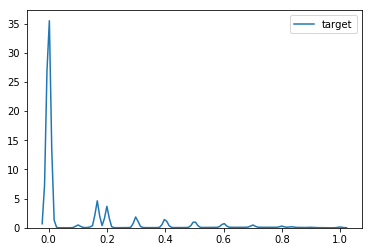

In [0]:
sns.kdeplot(train.target)

In [0]:
train['target'].describe()

count    1.804874e+06
mean     1.030173e-01
std      1.970757e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e-01
max      1.000000e+00
Name: target, dtype: float64

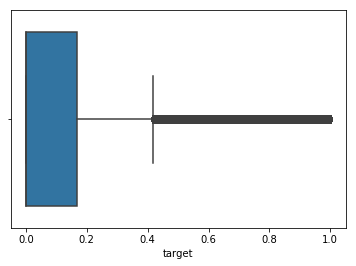

In [0]:
sns.boxplot(train.target)

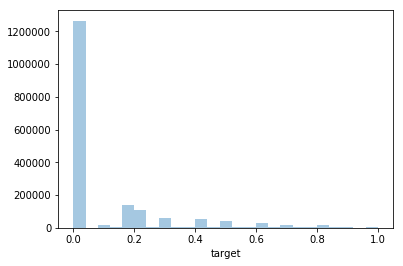

In [0]:
sns.distplot(train.target, bins=25, kde=False)

The length of the comments varies a lot.

In [0]:
comm_len = train.comment_text.map(lambda x: len(x))

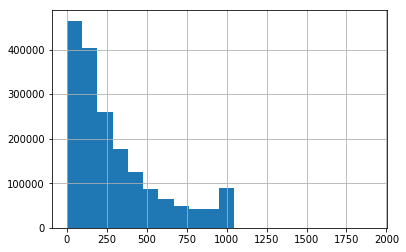

In [0]:
comm_len.hist(bins=20)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


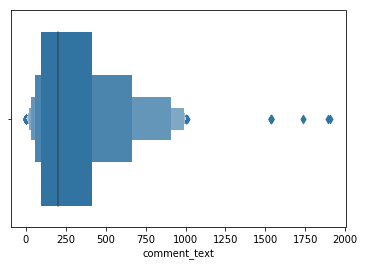

In [0]:
sns.boxenplot(comm_len)

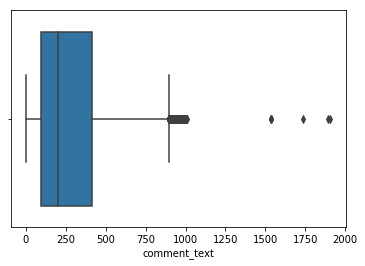

In [0]:
sns.boxplot(comm_len)

In [0]:
# lets check comment size by their target values
check = pd.DataFrame({'target': train.target, 'comment_len':comm_len})
check.head()

,target,comment_len
0,0.000000,101
1,0.000000,114
2,0.000000,86
3,0.000000,84
4,0.893617,36


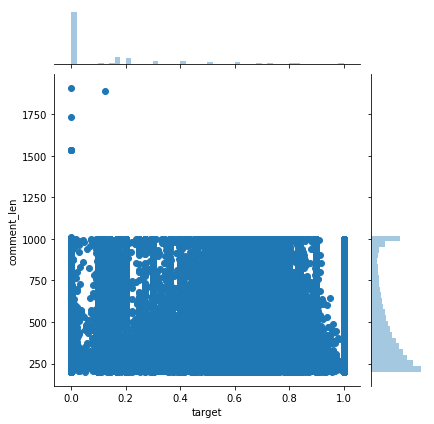

In [0]:
sns.jointplot(x='target', y='comment_len', data=check[check.comment_len>200])

In [0]:
# lets see how toxic and nox toxic comment look like
display(print(f"Non toxic comment : \n \t{train.comment_text[0]} \nToxic comment: \n \t{train.comment_text[4]}")) 

Non toxic comment : 
 	This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done! 
Toxic comment: 
 	haha you guys are a bunch of losers.


None

In [0]:
len(train), len(test)

(1804874, 97320)

In [0]:
train.comment_text.isna().sum(), test.comment_text.isna().sum()

(0, 0)

### Building the model

In [0]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): return re_tok.sub(r' \1 ', s).split()